# LightGMB

In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import numpy
import torch.nn
import torch.nn.functional
from torch.utils.data import Dataset, DataLoader
import torch.optim
import numpy.random
import numpy as np
import math
import pandas as pd
import copy
import time
from sklearn.preprocessing import LabelEncoder
import torch.nn
import torch.nn.functional
import torch.optim
import numpy.random
import math
import pandas
from sklearn.preprocessing import LabelEncoder

### Load Data

In [85]:
train_df = pd.read_csv('train_deleted.csv', dtype={'fullVisitorId': 'str'})

In [86]:
test_df = pd.read_csv('test_deleted.csv', dtype={'fullVisitorId': 'str'})

In [87]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  set()


We can delete the variable that is not in test dataset.
Also, visitId is not necessary since we can use fullvisitId.

In [88]:
train_df.drop(['visitId'], axis=1, inplace=True)
test_df.drop(['visitId'], axis=1, inplace=True)

### Train Model

In [89]:
cols = train_df.columns
num_cols = train_df._get_numeric_data().columns
factor_cols = list(set(cols) - set(num_cols))

In [90]:
factor_cols

['channelGrouping',
 'device.browser',
 'customDimensions.value',
 'geoNetwork.continent',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.country',
 'fullVisitorId',
 'geoNetwork.subContinent',
 'trafficSource.campaign',
 'geoNetwork.region',
 'geoNetwork.networkDomain',
 'trafficSource.source',
 'trafficSource.referralPath',
 'geoNetwork.city',
 'trafficSource.medium',
 'geoNetwork.metro']

In [91]:
num_cols = ['visitNumber', 'visitStartTime', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite']
# 'date',

In [92]:
factor_cols = ['channelGrouping',
 'trafficSource.medium',
 'customDimensions.value',
 'device.deviceCategory',
 'geoNetwork.region',
 'geoNetwork.country',
 'geoNetwork.networkDomain',
 'geoNetwork.continent',
 'geoNetwork.metro',
 'device.operatingSystem',
 'geoNetwork.subContinent',
 'trafficSource.source',
 'trafficSource.referralPath',
 'trafficSource.campaign',
 'geoNetwork.city',
 'device.browser',
 'trafficSource.isTrueDirect']

In [93]:
train_df.head(1)

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,...,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactionRevenue,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions.value
0,Organic Search,20171016,3162355547410993243,1,1508198450,Firefox,desktop,Windows,not available in demo dataset,Europe,...,1.0,1.0,82.0,0.0,(not set),False,organic,none,google,EMEA


In [95]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

for col in factor_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

channelGrouping
trafficSource.medium
customDimensions.value
device.deviceCategory
geoNetwork.region
geoNetwork.country
geoNetwork.networkDomain
geoNetwork.continent
geoNetwork.metro
device.operatingSystem
geoNetwork.subContinent
trafficSource.source
trafficSource.referralPath
trafficSource.campaign
geoNetwork.city
device.browser
trafficSource.isTrueDirect


In [96]:
msk = numpy.random.rand(len(train_df)) < 0.8
dev_df = train_df[msk]
val_df = train_df[~msk]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[list(factor_cols) + list(num_cols)] 
val_X = val_df[list(factor_cols) + list(num_cols)] 
test_X = test_df[list(factor_cols) + list(num_cols)] 

In [98]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    print('Saving model...')
    model.save_model('model.txt')
    print ('Success!')
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.50749
[200]	valid_0's rmse: 1.49925
[300]	valid_0's rmse: 1.49805
Early stopping, best iteration is:
[292]	valid_0's rmse: 1.49774
Saving model...
Success!


In [99]:
bst = lgb.Booster(model_file='model.txt')

In [100]:
bst.predict(data=[[1.0,2,3,4,5,6,7,8],[1,2,3,4,5,6,7,8]])

array([-0.26076491, -0.26076491])

In [101]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.5049488379773472


In [129]:
test_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
test_pred_df["transactionRevenue"] = test_df["totals.transactionRevenue"].values
test_pred_df["PredictedRevenue"] = np.expm1(pred_test)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
test_pred_df = np.log1p(test_pred_df["transactionRevenue"].values)
                        
#test_df = test_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
test_df['totals.transactionRevenue_ln'] = np.log1p(test_df["totals.transactionRevenue"].values)
true_value = list(test_df['totals.transactionRevenue_ln'].values)

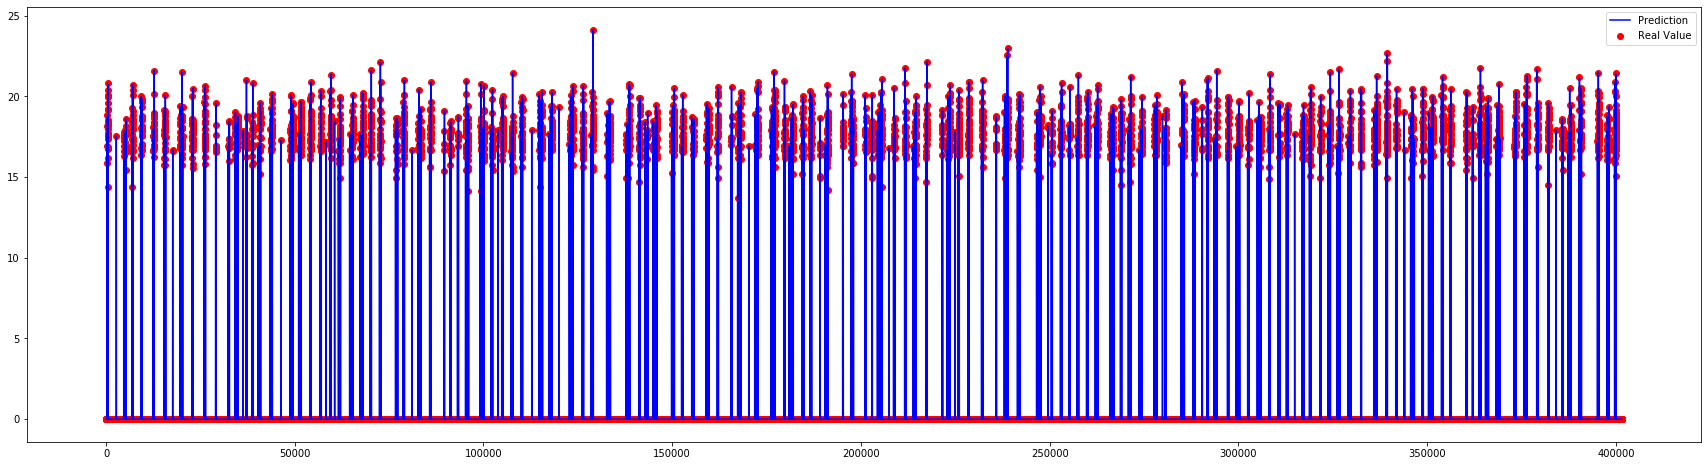

In [131]:
fig = plt.figure(figsize=(30,8))
ax = plt.axes()

ax.plot(range(len(test_pred_df)), list(test_pred_df), color = 'blue', label='Prediction')
ax.scatter(range(len(true_value)), list(true_value), color = 'red', label='Real Value')
ax.legend(loc='best')
plt.show()

In [18]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [19]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000196310838896290,2.023829
1,0000268499301061358,0.000000
2,0000528281082051132,0.017788
3,0000900085223565423,0.000000
4,000101445922736554,0.000000


### Feature Importance

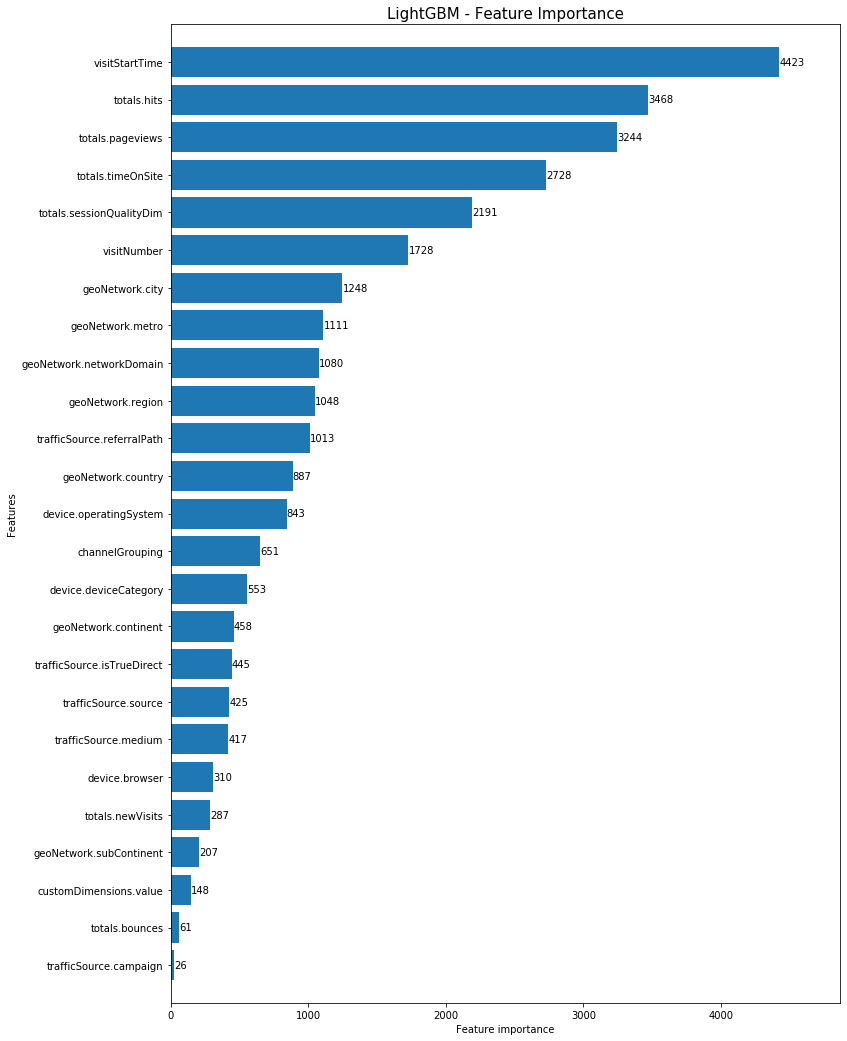

In [20]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

"visitStartTime" turn out to be the most important feature followed by "totals.hits" and "totals.pageviews".

In [34]:
train_df.loc[:, "totals.transactionRevenue_ln"] = np.log1p(train_df["totals.transactionRevenue"].fillna(0).astype("float"))

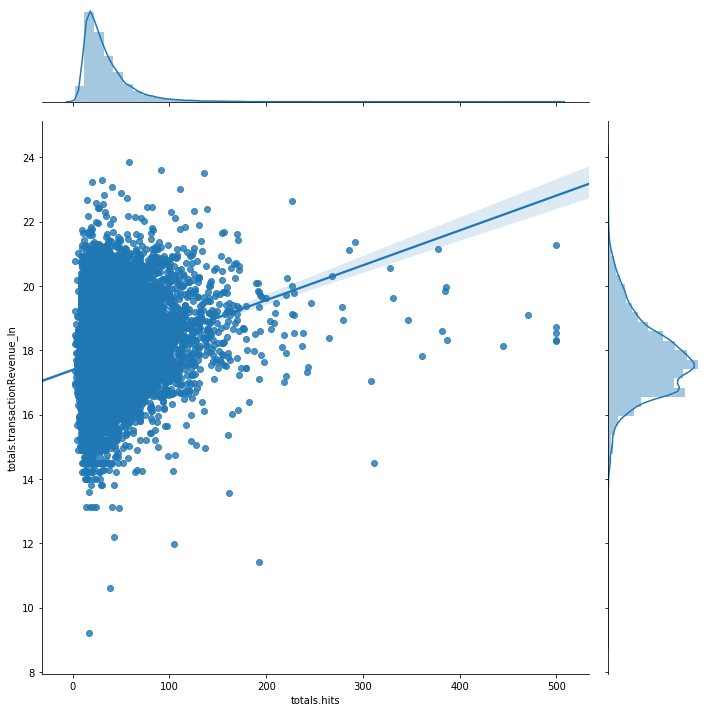

In [35]:
g = sns.jointplot('totals.hits', 'totals.transactionRevenue_ln', data=train_df[train_df['totals.transactionRevenue_ln'] > 0],
                 kind='reg', height=10)

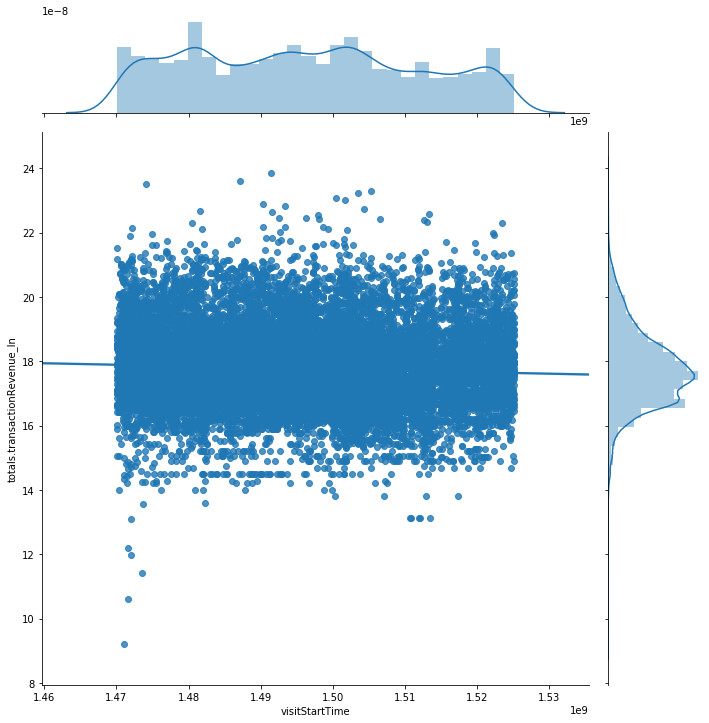

In [36]:
g = sns.jointplot('visitStartTime', 'totals.transactionRevenue_ln', data=train_df[train_df['totals.transactionRevenue_ln'] > 0],
                 kind='reg', height=10)

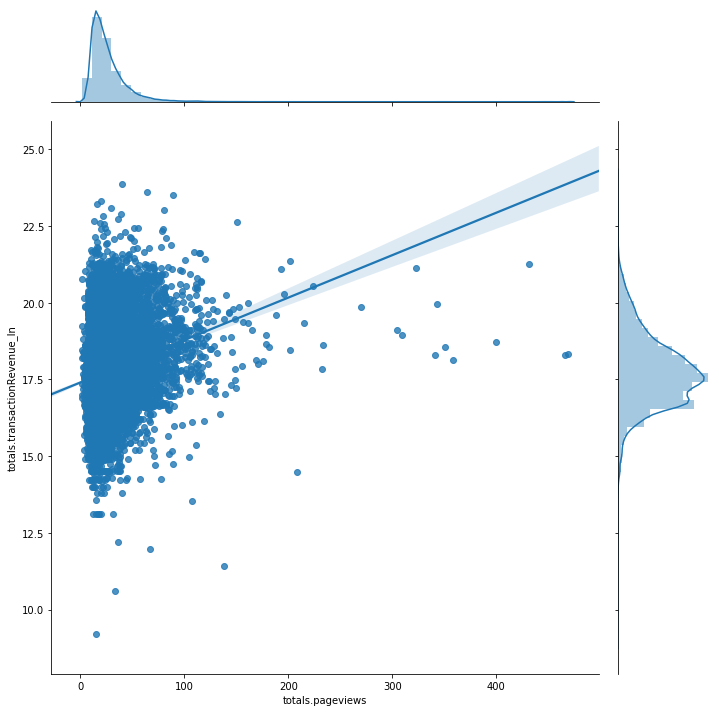

In [37]:
g = sns.jointplot('totals.pageviews', 'totals.transactionRevenue_ln', data=train_df[train_df['totals.transactionRevenue_ln'] > 0],
                 kind='reg', height=10)